In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm import tqdm

from networks.cnn import CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

/Users/bliu/Documents/adversarial-networks/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
# Download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

#create smaller dataset to test with
mini_train_idx = torch.utils.data.SubsetRandomSampler(np.arange(200)) # get the first 200 images
mini_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, sampler=mini_train_idx) 

Files already downloaded and verified


In [3]:
# Create the model
model = CNN().to(device)
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

In [4]:
# Train the model
progress = tqdm(total=len(train_loader)*EPOCHS, desc="Training") # add a progress bar
for epoch in range(EPOCHS):
    for images, labels in train_loader:
        model.train()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.update(1)
    
    progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

Training:  10%|█         | 786/7820 [00:29<04:09, 28.14it/s]

Epoch [1/10], Loss: 0.9059


Training:  20%|██        | 1567/7820 [00:58<03:35, 28.96it/s]

Epoch [2/10], Loss: 0.8051


Training:  30%|███       | 2351/7820 [01:27<03:12, 28.37it/s]

Epoch [3/10], Loss: 0.6936


Training:  40%|████      | 3132/7820 [01:56<02:55, 26.70it/s]

Epoch [4/10], Loss: 1.2584


Training:  50%|█████     | 3916/7820 [02:24<02:05, 31.10it/s]

Epoch [5/10], Loss: 0.9563


Training:  60%|██████    | 4697/7820 [02:50<01:42, 30.36it/s]

Epoch [6/10], Loss: 0.7343


Training:  70%|███████   | 5476/7820 [03:17<01:16, 30.79it/s]

Epoch [7/10], Loss: 0.5297


Training:  80%|████████  | 6259/7820 [03:44<00:51, 30.27it/s]

Epoch [8/10], Loss: 0.5524


Training:  90%|█████████ | 7043/7820 [04:10<00:25, 31.01it/s]

Epoch [9/10], Loss: 0.2894


Training: 100%|██████████| 7820/7820 [04:36<00:00, 31.64it/s]

Epoch [10/10], Loss: 0.4730


Training: 100%|██████████| 7820/7820 [04:50<00:00, 31.64it/s]

In [5]:
#saving model
torch.save(model.state_dict(), "models/cnn.pth")
print("Saved PyTorch Model State to cnn.pth")

Saved PyTorch Model State to cnn.pth


In [6]:

#loading the pretrained model
model = CNN()
model.load_state_dict(torch.load("models/cnn.pth"))
model.to(device)
model.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=64, bias=True)
  )
)

In [7]:
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

with torch.no_grad():
    for inputs, labels in test_loader:
        #for every batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()
        losses.append(loss.cpu().numpy())
        accuracies.append(accuracy.cpu().numpy())

loss, accuracy = np.mean(losses), np.mean(accuracies)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 1.1099, Accuracy: 0.6728


In [22]:
# Fast gradient sign method
def fgsm(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [28]:
# Adversarial test (but technically also train)

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "models/cnn.pth"
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = CNN().to(device)
model.load_state_dict(torch.load(pretrained_model))
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def test( model, device, test_loader, epsilon,criterion, optimizer ):
    correct = 0
    adv_examples = []
    for images, labels in test_loader:
        # Send the data and label to the device
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        images.requires_grad = True

        # Forward pass the data through the model
        output = model(images) 
        init_pred = torch.max(output, dim=1)[1] # get the index of the max log-probability
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect datagrad
        data_grad = images.grad.data

        # Call FGSM Attack
        #potential error: pass multiple images instead of image??
        perturbed_images = fgsm(images, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_images)

        final_pred = torch.max(output, dim=1)[1] # get the index of the max log-probability
        correct_idx = (final_pred == labels)
        correct += sum(correct_idx.to(torch.float32)).item()

        # print(correct)
        incorrect_idx = (final_pred != labels)

        #saving examples of perturbed images for later visualization
        if len(adv_examples) < 5:
            # Save some adv examples for visualization later
            # p is the single perturbed image, y is the correct label, initial and final and pre- and post-fgsm predictions
            for initial, final, p, y in zip(init_pred[incorrect_idx], final_pred[incorrect_idx], perturbed_images[incorrect_idx], labels[incorrect_idx]):
                adv_ex = p.squeeze().detach().cpu().numpy()
                adv_examples.append( (initial.item(), final.item(), y.item(), adv_ex) )
                # returned adv_examples is 1 x batchsize x 4
            
            # Special case for saving 0 epsilon examples
            if epsilon == 0:
                for initial, final in zip(init_pred[correct_idx], final_pred[correct_idx]):
                    adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                    adv_examples.append( (initial.item(), final.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_dataset))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataset), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

accuracies = []
examples = []

epsilons = [0.0] #overwriting epsilon for faster testing
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, criterion, optimizer)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.0	Test Accuracy = 6854.0 / 10000 = 0.6854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


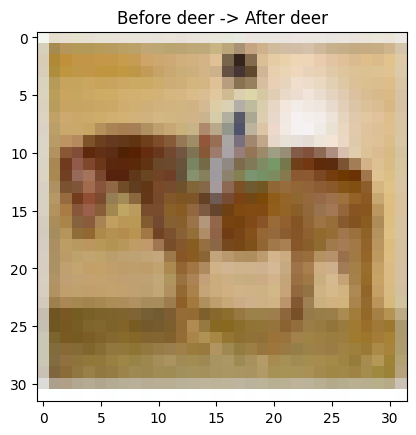

In [20]:
#WIP: print the adversarial examples saved during the above program
# Plot several examples of adversarial samples at each epsilon
import matplotlib.pyplot as plt
import torchvision

def imshow(img, before, after):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Before {} -> After {}".format(before, after))
    plt.show()

# print(examples[1][0][2])
# images = torch.tensor(examples[1][0][2][0])
images = torch.tensor(examples[0][0][3])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
imshow(torchvision.utils.make_grid(images), classes[examples[0][0][0]], classes[examples[0][0][1]])


# cnt = 0

# plt.figure()
# for i in range(len(epsilons)):
#     for j in range(len(examples[i])):
#         cnt += 1
#         plt.subplot(len(epsilons),len(examples[0]),cnt)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         if j == 0:
#             plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
#         orig,adv,ex = examples[i][j]
#         plt.title("{} -> {}".format(orig, adv))
#         plt.imshow(ex)
# plt.tight_layout()
# plt.show()